# Grover's Algorithm and Amplitude Amplification

Grover's algorithm is one of the most famous quantum algorithms introduced by Lov Grover in 1996 \[1\]. It has initially been proposed for unstructured search problems, i.e. for finding a marked element in a unstructured database. However, Grover's algorithm is now a subroutine to several other algorithms, such as Grover Adaptive Search \[2\]. For the details of Grover's algorithm, please see [Grover's Algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html) in the Qiskit textbook.

Qiskit implements Grover's algorithm in the `Grover` class. This class also includes the generalized version, Amplitude Amplification \[3\], and allows setting individual iterations and other meta-settings to Grover's algorithm.

**References:**

\[1\]: L. K. Grover, A fast quantum mechanical algorithm for database search. Proceedings 28th Annual Symposium on
the Theory of Computing (STOC) 1996, pp. 212-219. https://arxiv.org/abs/quant-ph/9605043

\[2\]: A. Gilliam, S. Woerner, C. Gonciulea, Grover Adaptive Search for Constrained Polynomial Binary Optimization.
https://arxiv.org/abs/1912.04088


\[3\]: Brassard, G., Hoyer, P., Mosca, M., & Tapp, A. (2000). Quantum Amplitude Amplification and Estimation. http://arxiv.org/abs/quant-ph/0005055

## Grover's algorithm

Grover's algorithm uses the Grover operator $\mathcal{Q}$ to amplify the amplitudes of the good states:

$$
    \mathcal{Q} = \mathcal{A}\mathcal{S_0}\mathcal{A}^\dagger \mathcal{S_f}
$$

Here, 
* $\mathcal{A}$ is the initial search state for the algorithm, which is just Hadamards, $H^{\otimes n}$ for the textbook Grover search, but can be more elaborate for Amplitude Amplification
* $\mathcal{S_0}$ is the reflection about the all 0 state
$$
    |x\rangle \mapsto \begin{cases} -|x\rangle, &x \neq 0 \\ |x\rangle, &x = 0\end{cases}
$$
* $\mathcal{S_f}$ is the oracle that applies 
$$
    |x\rangle \mapsto (-1)^{f(x)}|x\rangle
$$ 
&nbsp;&nbsp;&nbsp;&nbsp;　where $f(x)$ is 1 if $x$ is a good state and otherwise 0.

In a nutshell, Grover's algorithm applies different powers of $\mathcal{Q}$ and after each execution checks whether a good solution has been found. 


### Running Grover's algorithm 

To run Grover's algorithm with the `Grover` class, firstly, we need to specify an oracle for the circuit of Grover's algorithm. In the following example, we use `QuantumCircuit` as the oracle of Grover's algorithm. However, there are several other class that we can use as the oracle of Grover's algorithm. We talk about them later in this tutorial.

Note that the oracle for `Grover` must be a _phase-flip_ oracle. That is, it multiplies the amplitudes of the of "good states" by a factor of $-1$. We explain later how to convert a _bit-flip_ oracle to a phase-flip oracle. 

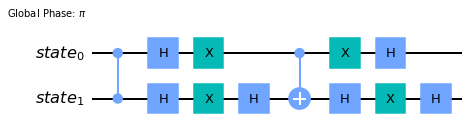

In [1]:
from qiskit import QuantumCircuit
from qiskit.algorithms import AmplificationProblem

# the state we desire to find is '11'
good_state = ['11']

# specify the oracle that marks the state '11' as a good solution
oracle = QuantumCircuit(2)
oracle.cz(0, 1)

# define Grover's algorithm
problem = AmplificationProblem(oracle, is_good_state=good_state)

# now we can have a look at the Grover operator that is used in running the algorithm
problem.grover_operator.draw(output='mpl')

Then, we specify a backend and call the `run` method of `Grover` with a backend to execute the circuits. The returned result type is a `GroverResult`. 

If the search was successful, the `oracle_evaluation` attribute of the result will be `True`. In this case, the most sampled measurement, `top_measurement`, is one of the "good states". Otherwise, `oracle_evaluation` will be False.


In [2]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover

aer_simulator = Aer.get_backend('aer_simulator')
grover = Grover(quantum_instance=aer_simulator)
result = grover.amplify(problem)
print('Result type:', type(result))
print()
print('Success!' if result.oracle_evaluation else 'Failure!')
print('Top measurement:', result.top_measurement)

Result type: <class 'qiskit.algorithms.amplitude_amplifiers.grover.GroverResult'>

Success!
Top measurement: 11


In the example, the result of `top_measurement` is `11` which is one of "good state". Thus, we succeeded to find the answer by using `Grover`.

### Using the different types of classes as the oracle of `Grover`
In the above example, we used `QuantumCircuit` as the oracle of `Grover`. 
However, we can also use `qiskit.quantum_info.Statevector` as oracle.
All the following examples are when $|11\rangle$ is "good state"

In [3]:
from qiskit.quantum_info import Statevector
oracle = Statevector.from_label('11')
problem = AmplificationProblem(oracle, is_good_state=['11'])

grover = Grover(quantum_instance=aer_simulator)
result = grover.amplify(problem)
print('Result type:', type(result))
print()
print('Success!' if result.oracle_evaluation else 'Failure!')
print('Top measurement:', result.top_measurement)

Result type: <class 'qiskit.algorithms.amplitude_amplifiers.grover.GroverResult'>

Success!
Top measurement: 11


Internally, the statevector is mapped to a quantum circuit:

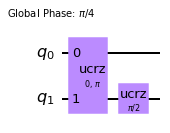

In [4]:
problem.grover_operator.oracle.draw(output='mpl')

Qiskit allows for an easy construction of more complex oracles:
* `PhaseOracle`: for parsing logical expressions such as `'~a | b'`. This is especially useful for solving 3-SAT problems and is shown in the accompanying [Grover Examples](07_grover_examples.ipynb) tutorial.

Here we'll use the `PhaseOracle` for the simple example of finding the state $|11\rangle$, which corresponds to `'a & b'`.

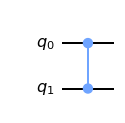

In [5]:
from qiskit.circuit.library.phase_oracle import PhaseOracle
from qiskit.exceptions import MissingOptionalLibraryError

# `Oracle` (`PhaseOracle`) as the `oracle` argument
expression = '(a & b)'
try:
    oracle = PhaseOracle(expression)
    problem = AmplificationProblem(oracle)
    display(problem.grover_operator.oracle.draw(output='mpl'))
except MissingOptionalLibraryError as ex:
    print(ex)

You can observe, that this oracle is actually implemented with three qubits instead of two!

That is because the `PhaseOracle` is not a phase-flip oracle (which flips the phase of the good state) but a bit-flip oracle. This means it flips the state of an auxiliary qubit if the other qubits satisfy the condition.
For Grover's algorithm, however, we require a phase-flip oracle. To convert the bit-flip oracle to a phase-flip oracle we sandwich the controlled-NOT by $X$ and $H$ gates, as you can see in the circuit above.

**Note:** This transformation from a bit-flip to a phase-flip oracle holds generally and you can use this to convert your oracle to the right representation.

## Amplitude amplification
Grover's algorithm uses Hadamard gates to create the uniform superposition of all the states at the beginning of the Grover operator $\mathcal{Q}$. If some information on the good states is available, it might be useful to not start in a uniform superposition but only initialize specific states. This, generalized, version of Grover's algorithm is referred to _Amplitude Amplification_.

In Qiskit, the initial superposition state can easily be adjusted by setting the `state_preparation` argument.

### State preparation

A `state_preparation` argument is used to specify a quantum circuit that prepares a quantum state for the start point of the amplitude amplification.
By default, a circuit with $H^{\otimes n} $ is used to prepare uniform superposition (so it will be Grover's search). The diffusion circuit of the amplitude amplification reflects `state_preparation` automatically.

state preparation circuit:


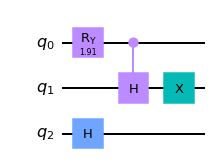

In [6]:
import numpy as np

# Specifying `state_preparation` 
# to prepare a superposition of |01>, |10>, and |11>
oracle = QuantumCircuit(3)
oracle.h(2)
oracle.ccx(0,1,2)
oracle.h(2)

theta = 2 * np.arccos(1 / np.sqrt(3))
state_preparation = QuantumCircuit(3)
state_preparation.ry(theta, 0)
state_preparation.ch(0,1)
state_preparation.x(1)
state_preparation.h(2)

# we only care about the first two bits being in state 1, thus add both possibilities for the last qubit
problem = AmplificationProblem(oracle, state_preparation=state_preparation, is_good_state=['110', '111'])

# state_preparation
print('state preparation circuit:')
problem.grover_operator.state_preparation.draw(output='mpl')

In [7]:
grover = Grover(quantum_instance=aer_simulator)
result = grover.amplify(problem)
print('Success!' if result.oracle_evaluation else 'Failure!')
print('Top measurement:', result.top_measurement)

Success!
Top measurement: 111


### Full flexibility

For more advanced use, it is also possible to specify the entire Grover operator by setting the `grover_operator` argument. This might be useful if you know more efficient implementation for $\mathcal{Q}$ than the default construction via zero reflection, oracle and state preparation.

The `qiskit.circuit.library.GroverOperator` can be a good starting point and offers more options for an automated construction of the Grover operator. You can for instance 
* set the `mcx_mode` 
* ignore qubits in the zero reflection by setting `reflection_qubits`
* explicitly exchange the $\mathcal{S_f}, \mathcal{S_0}$ and $\mathcal{A}$ operations using the `oracle`, `zero_reflection` and `state_preparation` arguments

For instance, imagine the good state is a three qubit state $|111\rangle$ but we used 2 additional qubits as auxiliary qubits. 

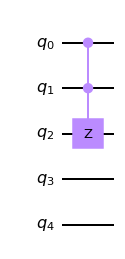

In [8]:
from qiskit.circuit.library import GroverOperator, ZGate

oracle = QuantumCircuit(5)
oracle.append(ZGate().control(2), [0, 1, 2])
oracle.draw(output='mpl')

Then, per default, the Grover operator implements the zero reflection on all five qubits.

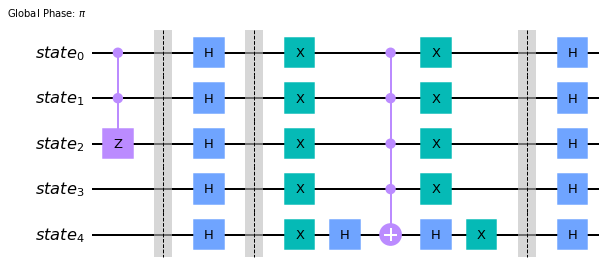

In [9]:
grover_op = GroverOperator(oracle, insert_barriers=True)
grover_op.draw(output='mpl')

But we know that we only need to consider the first three:

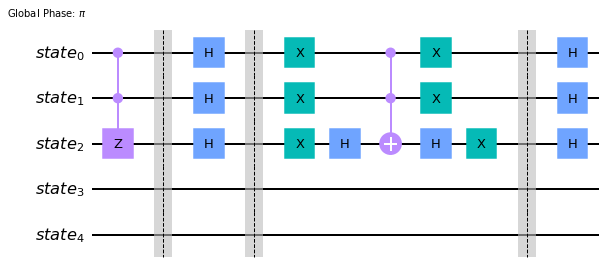

In [10]:
grover_op = GroverOperator(oracle, reflection_qubits=[0, 1, 2], insert_barriers=True)
grover_op.draw(output='mpl')

## Dive into other arguments of `Grover`
`Grover` has arguments other than `oracle` and `state_preparation`. We will explain them in this section.

### Specifying `good_state`
`good_state` is used to check whether the measurement result is correct or not internally. It can be a list of binary strings, a list of integer, `Statevector`, and Callable. If the input is a list of bitstrings, each bitstrings in the list represents a good state. If the input is a list of integer, each integer represent the index of the good state to be $|1\rangle$. If it is a `Statevector`, it represents a superposition of all good states.


In [11]:
# a list of binary strings good state
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
good_state = ['11', '00']
problem = AmplificationProblem(oracle, is_good_state=good_state)
print(problem.is_good_state('11'))

True


In [12]:
# a list of integer good state
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
good_state = [0, 1]
problem = AmplificationProblem(oracle, is_good_state=good_state)
print(problem.is_good_state('11'))

True


In [13]:
from qiskit.quantum_info import Statevector

# `Statevector` good state
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
good_state = Statevector.from_label('11')
problem = AmplificationProblem(oracle, is_good_state=good_state)
print(problem.is_good_state('11'))

True


In [14]:
# Callable good state
def callable_good_state(bitstr):
    if bitstr == "11":
        return True
    return False

oracle = QuantumCircuit(2)
oracle.cz(0, 1)
problem = AmplificationProblem(oracle, is_good_state=good_state)
print(problem.is_good_state('11'))

True


### The number of `iterations`

The number of repetition of applying the Grover operator is important to obtain the correct result with Grover's algorithm. The number of iteration can be set by the `iteration` argument of `Grover`. The following inputs are supported:
* an integer to specify a single power of the Grover operator that's applied
* or a list of integers, in which all these different powers of the Grover operator are run consecutively and after each time we check if a correct solution has been found

Additionally there is the `sample_from_iterations` argument. When it is `True`, instead of the specific power in `iterations`, a random integer between 0 and the value in `iteration` is used as the power Grover's operator. This approach is useful when we don't even know the number of solution.

For more details of the algorithm using `sample_from_iterations`, see [4].

**References:**

[4]: Boyer et al., Tight bounds on quantum searching [arxiv:quant-ph/9605034](https://arxiv.org/abs/quant-ph/9605034)

In [15]:
# integer iteration
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
problem = AmplificationProblem(oracle, is_good_state=['11'])
grover = Grover(iterations=1)

In [16]:
# list iteration
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
problem = AmplificationProblem(oracle, is_good_state=['11'])
grover = Grover(iterations=[1, 2, 3])

In [17]:
# using sample_from_iterations
oracle = QuantumCircuit(2)
oracle.cz(0, 1)
problem = AmplificationProblem(oracle, is_good_state=['11'])
grover = Grover(iterations=[1, 2, 3], sample_from_iterations=True)

When the number of solutions is known, we can also use a static method `optimal_num_iterations` to find the optimal number of iterations. Note that the output iterations is an approximate value. When the number of qubits is small, the output iterations may not be optimal.


In [18]:
iterations = Grover.optimal_num_iterations(num_solutions=1, num_qubits=8)
iterations

12

### Applying `post_processing`
We can apply an optional post processing to the top measurement for ease of readability. It can be used e.g. to convert from the bit-representation of the measurement `[1, 0, 1]` to a DIMACS CNF format `[1, -2, 3]`.

In [19]:
def to_DIAMACS_CNF_format(bit_rep):
    return [index+1 if val==1 else -1 * (index + 1) for index, val in enumerate(bit_rep)]

oracle = QuantumCircuit(2)
oracle.cz(0, 1)
problem = AmplificationProblem(oracle, is_good_state=['11'], post_processing=to_DIAMACS_CNF_format)
problem.post_processing([1, 0, 1])

[1, -2, 3]

In [20]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright